In [1]:
#useful: https://www.kdnuggets.com/2018/04/robust-word2vec-models-gensim.html

import csv
import nltk
import re
import numpy as np
import datetime
import time
import gensim, logging
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist
from scipy.spatial.distance import cosine
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.spatial import cKDTree
from gensim.models import Word2Vec
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

C:\Users\samir\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


# Load data

In [2]:
with open('./android/ebay/total_info.txt') as f:
    reader = csv.reader(f, delimiter="\t")
    d = list(reader)

ratings = []
reviews = []
titles = []
dates = []
versions = []

for line in d:
    vals = line[0].split("******")
    ratings.append(float(vals[0]))
    reviews.append(vals[1])
    dates.append(vals[2])
    versions.append(vals[3])

In [3]:
with open('./ios/noaa-radar-pro-severe-weather/total_info.txt') as f:
    reader = csv.reader(f, delimiter="\t")
    d = list(reader)

ratings = []
reviews = []
titles = []
dates = []
versions = []

for line in d:
    vals = line[0].split("******")
    ratings.append(float(vals[0]))
    reviews.append(vals[1])
    titles.append(vals[2])
    dates.append(vals[3])
    versions.append(vals[4])
    


In [4]:
len(reviews)

8368

In [5]:
reviews[0:10]

['when there be a thunderstorm in singapore , the radar picture show nothing .',
 'i hunt and fish . therefore i care about the weather , both about personal safety and have great condition . i like this app a lot .',
 'i love the drill down capability start from detail map into specific forecast .',
 "the one app i pay for and i couldn't be more disappoint . i guess this can provide many people with enough info , but it lack detail forecast and option for how you want it to work . instead , my 5 star vote go to weather underground's storm . i believe it's free , so give it a try and see what you think .",
 'very trust worthy ! i always have my location on to make sure i never miss a severe weather alert near me . the app work great !',
 "i'm enjoy this app . i could not ask for s better weather radar map .",
 'show you stuff . work great !',
 'this be a waste of money .',
 'you can get the same thing from a free app . nothing special about this one . wish i have not spend the money .'

# Preprocess all review text

In [6]:
stop_words = stopwords.words('english')
def custom_preprocessor(text):
    porter = PorterStemmer()

    #split into sentences
    sentences = sent_tokenize(text)
    
    final_sentences = []
    
    for sentence in sentences:
        sentence_split = sentence.split(" ")
        
        #remove words in not in stop words, and make lowercase
        words = [word.lower() for word in sentence_split if word.lower() not in stop_words]
        #get rid of words with non alphanumeric characters in it
        #(should we replace these with a token?)
        words = [word for word in words if word.isalpha()]
        #stem words
        words = [porter.stem(word) for word in words]

        final_sentences.append(" ".join(words))
        
        #consider joining sentences with a stop token
    return " ".join(final_sentences), final_sentences, sentences

In [7]:
custom_preprocessor('hi im bob. hello bye.')

('hi im hello', ['hi im', 'hello'], ['hi im bob.', 'hello bye.'])

In [8]:
processed_reviews = []
processed_sentences = []
raw_sentences = []
for review in reviews:
    processed_review = custom_preprocessor(review) 
    processed_reviews.append(processed_review[0])
    processed_sentences.append(processed_review[1])
    raw_sentences.append(processed_review[2])

In [9]:
processed_reviews[0]

'thunderstorm singapor radar pictur show noth'

In [10]:
#get rid of reviews that are empty after preprocessing
#(not that many)

processed_review_lens = np.array([len(review) for review in [r.split(" ") for r in processed_reviews]])
#if using stop tokens "<END>" then empty reviews have a length of 6
nonzero_indeces = np.where(processed_review_lens > 0)


final_reviews =  [review.split(" ") for review in np.array(processed_reviews)[nonzero_indeces]]
final_reviews_unprocessed =  np.array(reviews)[nonzero_indeces]
final_ratings = np.array(ratings)[nonzero_indeces]
#final_titles = np.array(titles)[nonzero_indeces]
final_dates = np.array(dates)[nonzero_indeces]
unique_dates = np.unique(np.array(final_dates))
unique_date_indices = []
for date in unique_dates:
        date_indices = np.where(np.array(final_dates)==date)[0]
        unique_date_indices.append(date_indices)
final_versions = np.array(versions)[nonzero_indeces]

In [11]:
len(final_reviews)

8368

In [12]:
#same for sentences
processed_sentences_flat = [item for sublist in processed_sentences for item in sublist]
raw_sentences_flat = [item for sublist in raw_sentences for item in sublist]
processed_review_sentence_lens = np.array([len(review) for review in processed_sentences_flat])
#if using stop tokens "<END>" then empty reviews have a length of 6
nonzero_indeces = np.where(processed_review_sentence_lens > 0)


final_sentences =  np.array([sentence.split(" ") for sentence in np.array(processed_sentences_flat)[nonzero_indeces]])
final_sentences_unprocessed =  np.array(raw_sentences_flat)[nonzero_indeces]

In [13]:
final_sentences[1]

['hunt', 'fish']

In [14]:
print(len(reviews))
print(len(final_reviews))

8368
8368


In [15]:
start = time.time()
model = Word2Vec(final_reviews, min_count=1)
#model.save("../../large files/youtube_w2v_stoptokens.model")
print(time.time() - start)

0.33011555671691895


In [16]:
model.wv.most_similar('freez', topn=5)

[('pass', 0.9996227622032166),
 ('second', 0.9996222257614136),
 ('big', 0.999618649482727),
 ('small', 0.9996182322502136),
 ('someth', 0.9996160268783569)]

# Clustering the reviews

In [17]:
#here we create a vector for each review,
#which will be the simple average of all word vectors in that review.
#these vectors will then be used for clustering, data reduction, etc.
avg_vectors = []
for review in final_reviews:
    avg_vectors.append(np.mean([model.wv[word] for word in review], axis=0))
    
avg_vectors = np.array(avg_vectors)  

In [18]:
avg_sentence_vectors = []

for sentence in final_sentences:
    avg_sentence_vectors.append(np.mean([model.wv[word] for word in sentence], axis=0))
    
avg_sentence_vectors = np.array(avg_sentence_vectors) 

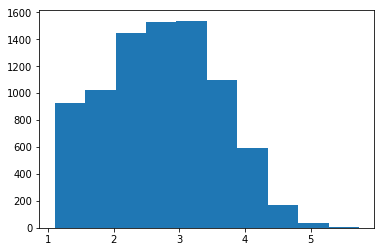

In [19]:
#review lengths are very positively skewed - we log transform them so it's more normal.
final_review_lengths = [np.log(len(review.split(" "))) for review in final_reviews_unprocessed]
plt.hist(final_review_lengths)

avg_vectors_w_lengths = [np.append(vector, length) for vector, length in zip(avg_vectors, final_review_lengths)]
avg_vectors_w_lengths_ratings = [np.append(vector, rating) for vector, rating in zip(avg_vectors_w_lengths, final_ratings)]

In [20]:
#scaling 
scaler = StandardScaler()
avg_vectors_scaled = scaler.fit_transform(avg_vectors)
#avg_vectors_scaled = scaler.fit_transform(avg_vectors)
#avg_vectors_w_lengths_scaled = scaler.fit_transform(avg_vectors_w_lengths)
#avg_vectors_w_lengths_ratings_scaled = scaler.fit_transform(avg_vectors_w_lengths_ratings)

In [21]:
print(avg_vectors.shape)
print(avg_vectors_scaled.shape)
#print(avg_vectors_w_lengths_scaled.shape)
#print(avg_vectors_w_lengths_ratings_scaled.shape)

(8368, 100)
(8368, 100)


In [22]:
word_vector = model.wv.get_vector('good')
vector2 = model.wv.get_vector('bad')
print(model.wv.distance('good', 'great'))
print(cosine(word_vector, vector2))

0.0001884010776642686
0.0007681846618652344


In [23]:
def find_relevant_reviews(key, avg_vectors, raw_text, n=1, scaled=False):
    
    indices = None
    distances = None
    
    key_processed = custom_preprocessor(key)[0]
    key_list = key_processed.split(' ')
    #filter to only those in the w2v model's covacbulary
    vocab = model.wv.vocab.keys()
    key_list_vocab_words = []
    key_list_nonvocab_words = []
    for word in key_list:
        if word in vocab:
            key_list_vocab_words.append(word)
        else:
            key_list_nonvocab_words.append(word)
    
    #only move on if the list isn't empty (i.e. if the key had no words in the vocab)
    if len(key_list_vocab_words) > 0:
        key_vector = np.mean([model.wv[word] for word in key_list_vocab_words if word in model.wv.vocab.keys()], axis=0)
        
        if scaled:
            key_vector = scaler.transform(np.array(key_vector).reshape(1,-1))

        distances = [1-cosine(key_vector, vector) for vector in avg_vectors]
        indices = np.argsort(distances)[-n:]
    else:
        print("Warning: none of the words in the query were in the model's vocabulary.")
    
    if len(key_list_nonvocab_words) > 0:
        print("Excluded words:", key_list_nonvocab_words)
        
    return indices, distances
    


In [24]:
def plot_topic_evolution(distances, query, relevance_threshold = 0.8):
    
    
    mean_distances = []
    n_relevant_reviews = []
    percent_relevant_reviews= []
    mean_ratings = []
    
    for date_indices in unique_date_indices:
        date_distances = np.array(distances)[date_indices]
        mean_distances.append(np.mean(date_distances))
        
        relevant_indeces = np.where(date_distances > relevance_threshold)[0]
        n = len(relevant_indeces)
        percent = 100*(n/len(date_indices))

        n_relevant_reviews.append(n)
        percent_relevant_reviews.append(percent)
        
        date_ratings = np.array(final_ratings)[date_indices][relevant_indeces]
        mean_ratings.append(np.mean(date_ratings))
        

    
    
    plt.figure(figsize=(14,5))
    plt.plot(range(len(unique_dates)), mean_distances, 'bo-')
    plt.xlabel('days from start of data collection')
    plt.ylabel('Average similarity')
    plt.title('Average cosine similarity for query - ' + query)
    plt.show()
    
    plt.figure(figsize=(14,5))
    plt.plot(range(len(unique_dates)), n_relevant_reviews, 'ro-')
    plt.xlabel('days from start of data collection')
    plt.ylabel('# relevant reviews')
    plt.title('Number of reviews relevant to the query - ' + query)
    plt.show()
    
    plt.figure(figsize=(14,5))
    plt.plot(range(len(unique_dates)), percent_relevant_reviews, 'go-')
    plt.xlabel('days from start of data collection')
    plt.ylabel('% relevant reviews')
    plt.title('Percent of reviews relevant to the query - '+ query)
    plt.show()
    
    plt.figure(figsize=(14,5))
    plt.plot(range(len(unique_dates)), mean_ratings, 'ko-')
    plt.xlabel('days from start of data collection')
    plt.ylabel('Mean rating')
    plt.title('Mean rating for reviews relevant to query - '+ query)
    plt.show()
    

In [ ]:
def print_relevant_reviews(indices, distances, n = 10):
    text = ""
    for i in range(len(indices)):
        index = indices[-(i+1)]
        text += "'"+str(final_reviews_unprocessed[index])+"' (Rating: "+str(final_ratings[index])+", Cosine similarity: )"+str(round(distances[index], 4))+"\n"
        
    return text

In [26]:
#interesting ones: 'fast forward button', 'crash', 'freeze', 'update'
query = 'good'

indices, distances = find_relevant_reviews(query, avg_vectors_scaled, final_reviews_unprocessed, n=10, scaled=True)
#indices, distances = find_relevant_reviews(query, avg_vectors, final_reviews_unprocessed, n=10, scaled=False)
for i in range(len(indices)):
    index = indices[-(i+1)]
    print(final_reviews_unprocessed[index])
    print("Rating:", final_ratings[index])
    print("Cosine similarity:", round(distances[index], 4))
    print('*******\n')

good for me .
Rating: 5.0
Cosine similarity: 1.0
*******

very good .
Rating: 5.0
Cosine similarity: 1.0
*******

very good .
Rating: 5.0
Cosine similarity: 1.0
*******

it be good just for 24hrs not any more .
Rating: 2.0
Cosine similarity: 1.0
*******

it's good !
Rating: 5.0
Cosine similarity: 1.0
*******

very good .
Rating: 4.0
Cosine similarity: 1.0
*******

very good !
Rating: 5.0
Cosine similarity: 1.0
*******

very good .
Rating: 5.0
Cosine similarity: 1.0
*******

very good .
Rating: 5.0
Cosine similarity: 1.0
*******

very good .
Rating: 5.0
Cosine similarity: 1.0
*******



C:\Users\samir\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\samir\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


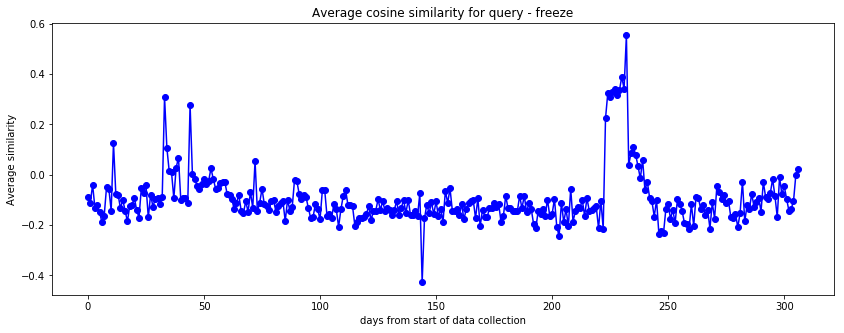

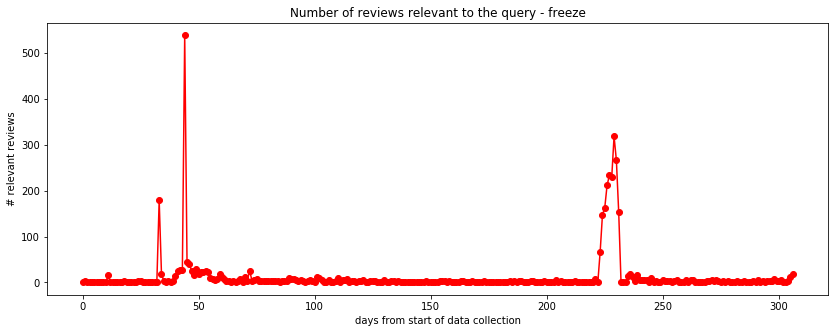

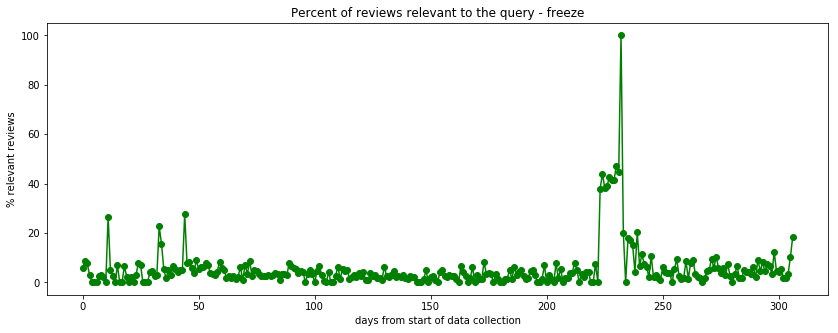

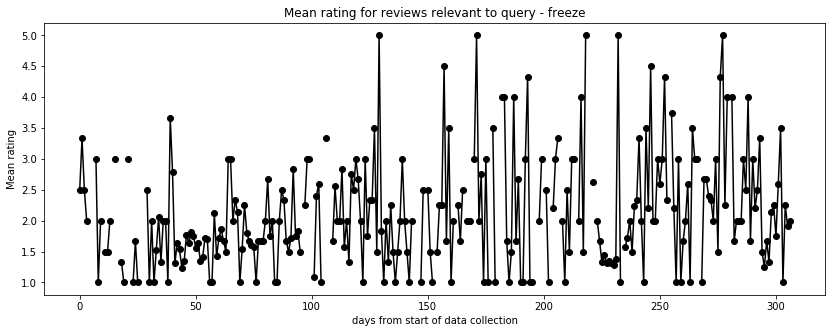

1.0292494297027588


In [150]:
start = time.time()
plot_topic_evolution(distances, query, relevance_threshold = 0.5)
print(time.time() - start)

# Clustering

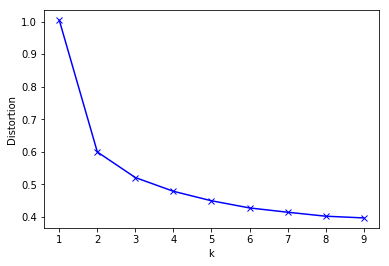

67.61557197570801 seconds


In [52]:
#Using the elbow plot method to try and determine how many clusters to go with
start = time.time()


K = range(1,10)
for vectors in [avg_vectors_scaled]:
    distortions = []
    for k in K:
        #print(k)
        kmeanModel = KMeans(n_clusters=k)
        kmeanModel.fit(vectors)
        distortions.append(sum(np.min(cdist(vectors, kmeanModel.cluster_centers_, 'cosine'), axis=1)) / vectors.shape[0])

    # Plot the elbow
    plt.plot()
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('')
    plt.show()
print(time.time() - start, "seconds")

In [42]:
#run the clustering algorithm
km = KMeans(n_clusters = 10)
km.fit(avg_vectors_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [19]:
def find_k_closest(centroids, data, k=1, distance_norm=2):
    kdtree = cKDTree(data)
    distances, indices = kdtree.query(centroids, k)
    return indices

In [20]:
#find and print the reviews closest to the centroid, i.e. the most represntative reviews

centroids = km.cluster_centers_ 
cluster_closest_indices = find_k_closest(centroids, avg_vectors, k=10)
n = 1
for cluster in cluster_closest_indices:
    print("Cluster", n)
    
    for index in cluster:
        pass
        print(final_reviews_unprocessed[index])
        print("\n")
    print("\n\n\n")
    n += 1

Cluster 1
i cant skip buffer video they load forever video wont start i need to close youtube and open again and still doesn't work ive be tryin to watch the same video but the ad just dont start and when i click for a new video just freeze .


i've be watch youtube for a while but today when i go to watch video , some video with ad keep freeze . the ad freeze and be load for a while . and most of the freeze video be video i like . please fix the problem because it be load really slow .


can you fix the problem where whenever i try to watch a video the video or the ad pause even though it's unpaused and just stay like that ? i can never seem to watch a video .


this app be fine until a few day ago . now video randomly won't play . i click on the video , and the first frame load , but no matter what the video just stop . the load bar show that the video be load , but the video just doesn't play . if i change apps and go back to youtube , the same thing happen and the video just freeze

In [21]:
cluster_labels = km.fit_predict(avg_vectors)

In [22]:
#use logistic regression to see what the most important words for each cluster is

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, r2_score, mean_squared_error

In [24]:
train_text, test_text, train_labels, test_labels = train_test_split(processed_reviews[nonzero_indeces], cluster_labels, random_state=2)
print(len(train_text))
print(len(test_text))
print(len(train_labels))
print(len(test_labels))

28263
9421
28263
9421


In [25]:
cv = CountVectorizer(min_df=1, ngram_range=(0,1))
cv_train_text = cv.fit_transform(train_text)
cv_test_text = cv.transform(test_text)

In [26]:
#run logistic regression model to predict cluster based on bag of words
lr = LogisticRegression()
lr.fit(cv_train_text, train_labels)
preds = lr.predict(cv_test_text)

#checking accuracy out of curiosity (although it's not really the point of any of this)
print(classification_report(test_labels, preds))

             precision    recall  f1-score   support

          0       0.89      0.85      0.87       435
          1       0.79      0.76      0.77      1037
          2       0.89      0.91      0.90       696
          3       0.88      0.83      0.85       811
          4       0.82      0.75      0.79       867
          5       0.78      0.74      0.76       903
          6       0.82      0.85      0.83      1803
          7       0.79      0.88      0.83       759
          8       0.74      0.75      0.75      1767
          9       0.79      0.81      0.80       343

avg / total       0.81      0.81      0.81      9421



In [27]:
#get the largest coefficient for each of the clusters, i.e.
#the words most predictive of that cluster
#and print them out

cv_featurenames = cv.get_feature_names()
max_indeces = []

for n in range(0,10):
    coefs = lr.coef_[n]
    maxes = np.argsort(coefs)[-20:]
    max_indeces.append(maxes)
for i in range(0, len(max_indeces)):
    print("Cluster", i+1)
    top_features = [cv_featurenames[index] for index in max_indeces[i]]
    #reverse, because getting the coefficients this way gives you a list
    #where the last element is the highest number
    print(", ".join(reversed(top_features)))
    print("****************")

Cluster 1
comment, repli, section, layout, read, old, horribl, new, confus, hate, ugli, back, review, bring, feel, mess, home, interfac, trash, terribl
****************
Cluster 2
io, version, pro, iphon, updat, failur, se, fex, forum, slightli, verif, smoothli, solid, crazi, hi, storag, server, dev, latest, app
****************
Cluster 3
wrong, error, retri, say, tap, someth, messag, tri, keep, reload, pop, sorri, tell, go, click, everi, press, alway, pick, happen
****************
Cluster 4
button, forward, doubl, rewind, hit, skip, screen, auto, second, annoy, bar, accident, landscap, ten, fast, thumb, minim, earbud, leav, part
****************
Cluster 5
subscrib, channel, subscript, sub, interest, suggest, recommend, notif, intent, post, pleaz, grey, relev, list, initi, search, see, luck, bunch, secondli
****************
Cluster 6
wifi, work, restart, reinstal, internet, freakin, strong, bump, connect, delet, open, noth, reset, anoy, offlin, fine, forget, enter, uninstal, zero
******

# Write data to files outside repo to upload to projector.tensorflow.org

In [28]:
with open('../../large files/tf_projector_data.tsv', 'w', newline='') as tsvfile:
    writer = csv.writer(tsvfile, delimiter='\t')
    for vector in avg_vectors:
        writer.writerow(vector)

In [29]:
centroids = km.cluster_centers_ 
cluster_closest_indices = find_k_closest(centroids, avg_vectors, k=100)
is_closest = [0]*len(final_reviews_unprocessed)
cluster_labels_closest_only = [0]*len(final_reviews_unprocessed)
i = 0
for cluster in cluster_closest_indices:    
    for index in cluster: 
        is_closest[index] = 1
        cluster_labels_closest_only[index] = i
    i += 1

In [30]:
with open('../../large files/tf_projector_metadata.tsv', 'w', newline='') as tsvfile:
    writer = csv.writer(tsvfile, delimiter='\t')
    writer.writerow(['review_text', 'cluster_label', 'is_closest', 'cluster_labels_closest_only'])
    for i in range(0, len(final_reviews_unprocessed)):
        writer.writerow([final_reviews_unprocessed[i], cluster_labels[i], is_closest[i], cluster_labels_closest_only[i]])